In [1]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv(r"C:/Users/Sina/Desktop/CODES/Sources/CLUSTERING/6(iris_dataset).csv")

# Select sepal and petal features separately
sepal_features = ['sepal_length', 'sepal_width']
petal_features = ['petal_length', 'petal_width']

sepal_data = data[sepal_features].fillna(0)
petal_data = data[petal_features].fillna(0)


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale features separately
scaler = StandardScaler()
scaled_sepal = scaler.fit_transform(sepal_data)
scaled_petal = scaler.fit_transform(petal_data)

# Apply PCA on sepal features (2 components)
pca_sepal_model = PCA(n_components=2, random_state=45)
pca_sepal = pca_sepal_model.fit_transform(scaled_sepal)

# Apply PCA on petal features (2 components)
pca_petal_model = PCA(n_components=2, random_state=45)
pca_petal = pca_petal_model.fit_transform(scaled_petal)

# Combine PCA results into one DataFrame
pca_df = pd.DataFrame(
    np.hstack((pca_sepal, pca_petal)),
    columns=['Sepal_PCA1', 'Sepal_PCA2', 'Petal_PCA1', 'Petal_PCA2']
)


In [3]:
from sklearn.cluster import DBSCAN

# Run DBSCAN on combined PCA features
dbscan = DBSCAN(eps=0.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(pca_df)

# Store DBSCAN cluster labels in original dataframe
data['DBSCAN_Cluster'] = dbscan_labels


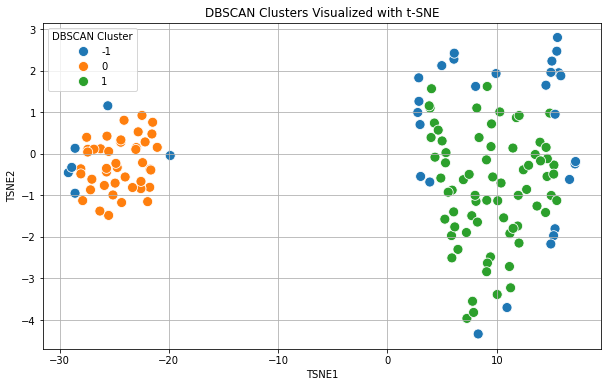

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensionality for visualization with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(pca_df)

# Add t-SNE results to dataframe
data['TSNE1'] = tsne_results[:, 0]
data['TSNE2'] = tsne_results[:, 1]

# Plot DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette='tab10', s=100)
plt.title("DBSCAN Clusters Visualized with t-SNE")
plt.legend(title='DBSCAN Cluster')
plt.grid(True)
plt.show()


In [5]:
# Select only non-noise points for KMeans
cleaned_data = pca_df[dbscan_labels != -1]


In [6]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

eps_values = [0.1, 0.3, 0.5, 0.7, 0.9]
min_samples_values = [2, 4, 6, 8]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_df)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        mask = labels != -1  # ignore noise for metrics

        if n_clusters > 1 and sum(mask) > 0:
            sil_score = silhouette_score(pca_df[mask], labels[mask])
            dbi_score = davies_bouldin_score(pca_df[mask], labels[mask])
            chi_score = calinski_harabasz_score(pca_df[mask], labels[mask])
            print(f"eps={eps:.2f}, min_samples={min_samples}, clusters={n_clusters}, "
                  f"Silhouette={sil_score:.3f}, DBI={dbi_score:.3f}, CHI={chi_score:.1f}")
        else:
            print(f"eps={eps:.2f}, min_samples={min_samples}, clusters={n_clusters}, "
                  "Insufficient clusters for evaluation")


eps=0.10, min_samples=2, clusters=2, Silhouette=1.000, DBI=0.000, CHI=1134691941210579750673788144975872.0
eps=0.10, min_samples=4, clusters=0, Insufficient clusters for evaluation
eps=0.10, min_samples=6, clusters=0, Insufficient clusters for evaluation
eps=0.10, min_samples=8, clusters=0, Insufficient clusters for evaluation
eps=0.30, min_samples=2, clusters=20, Silhouette=0.415, DBI=0.604, CHI=148.1
eps=0.30, min_samples=4, clusters=5, Silhouette=0.473, DBI=0.698, CHI=169.3
eps=0.30, min_samples=6, clusters=2, Silhouette=0.634, DBI=0.497, CHI=67.9
eps=0.30, min_samples=8, clusters=2, Silhouette=0.647, DBI=0.480, CHI=72.5
eps=0.50, min_samples=2, clusters=9, Silhouette=0.191, DBI=0.644, CHI=66.0
eps=0.50, min_samples=4, clusters=2, Silhouette=0.652, DBI=0.500, CHI=332.7
eps=0.50, min_samples=6, clusters=4, Silhouette=0.463, DBI=0.708, CHI=205.4
eps=0.50, min_samples=8, clusters=3, Silhouette=0.601, DBI=0.582, CHI=271.7
eps=0.70, min_samples=2, clusters=3, Silhouette=0.516, DBI=0.517,

In [7]:
from sklearn.cluster import KMeans

# Apply KMeans clustering on filtered (non-noise) data
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(cleaned_data)

# Assign KMeans labels back to original dataframe only for non-noise points
data.loc[dbscan_labels != -1, 'KMeans_Cluster'] = kmeans_labels


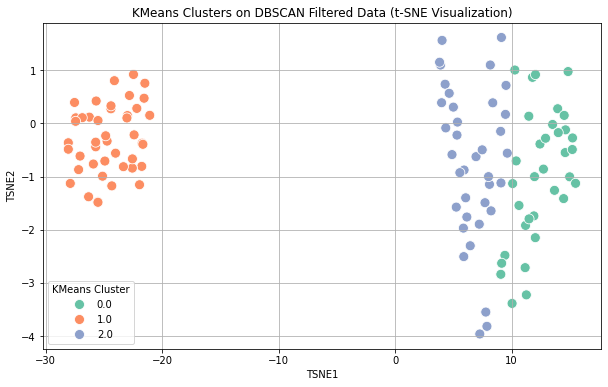

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data[dbscan_labels != -1], x='TSNE1', y='TSNE2',
    hue='KMeans_Cluster', palette='Set2', s=100
)
plt.title("KMeans Clusters on DBSCAN Filtered Data (t-SNE Visualization)")
plt.legend(title='KMeans Cluster')
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(cleaned_data, kmeans_labels)
dbi = davies_bouldin_score(cleaned_data, kmeans_labels)
chi = calinski_harabasz_score(cleaned_data, kmeans_labels)

print("KMeans Clustering Evaluation on DBSCAN-filtered Data:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")
print(f"Calinski-Harabasz Index: {chi:.3f}")


KMeans Clustering Evaluation on DBSCAN-filtered Data:
Silhouette Score: 0.490
Davies-Bouldin Index: 0.823
Calinski-Harabasz Index: 284.411
